In [35]:
from train_model import *

In [36]:
import seaborn as sns

In [94]:
models = {
    # '0409_env6_3res_1_3_5': '1_3_5',
    # '0409_env6_1res_1': '1',
    # '0409_env6_1res_3': '3',    
    # '0409_env6_1res_5': '5',

    # '0405_env16_3res': '1_5_16',
    # '0410_env16_1res_1': '1',
    # '0410_env16_1res_5': '5',
    # '0409_env16_1res': '16',
    # '0410_env16_1res_16_v2': '16',
    # '0410_env32_1res': '32'

    # '0418_env20_1res_1': '1',
    # '0419_env20_1res_3': '3',
    # '0418_env20_1res_5': '5',
    # '0418_env20_1res_10': '10',
    # '0418_env20_1res_20': '20',
    # '0419_env20_3res_1_3_5': '1_3_5',
    # '0422_env20_2res_1_10': '1_10',
    # '0422_env20_4res_1_3_5_10': '1_3_5_10',
    # '0418_env20_4res': '1_5_10_20',
    # '0419_env20_5res': '1_3_5_10_20'

    # '0409_env6_1res_1': '1',
    # '0416_env6_1res_1_autoencoder': '1_autoencoder',
    # '0409_env6_1res_5': '5',
    # '0416_env6_1res_5_autoencoder': '5_autoencoder'

    # '0425_sat128_1res_resnet_bs1024': '250m',
    # '0426_sat128_1res_25': '630m',
    # '0426_sat128_1res_52': '1250m',
    # '0430_sat18_3res': '3res_bs256!!'

    # '0501_sat128_1res_25_bs256': '250m',
    # '0501_sat128_1res_63_bs256': '630m',
    # '0501_sat128_1res_125_bs256': '1250m',
    # '0501_sat128_3res_2174_bs256': '3res'

    # '0510_env3res': 'env_3res',
    # '0510_sat3res': 'sat_3res',
    # '0510_multimodel_multires': 'env_3res_sat_3res'

    # '0604_env1_1': 'env1_1',
    # '0604_env1_10': 'env1_10',
    # '0604_env1_1_other_n_filters': 'env1_1_other_n_filter',
    # '0605_env1_1_yet_other_n_filters': 'env1_1_yet_other_n_fliter',
    # '0605_env1_1_train_set_only_val_species': 'env1_1_train_on_val_species',
    # '0604_sat25_25': 'sat25_25',
    # '0604_sat25_128': 'sat25_128'

    '0618_env_1': 'env_1',
    # '0615_env_1_patchsize_5': 'env_1_ps5',
    # '0612_env_3': 'env_3',
    '0612_env_5': 'env_5', # (1*5conv)
    # '0613_env_5_2convs3x3': 'env_5 (2*3convs)',
    '0612_env_9': 'env_9',
    # '0611_env13_no_dilated_convs': 'env_13',
    '0612_env_17': 'env_17',
    '0612_env_25': 'env_25',
    # '0614_env_1_3_9_17': 'env_1_3_9_17',
    # '0615_env_1_3_9': 'env_1_3_9',
    # '0615_env_1_3_5': 'env_1_3_5'
    '0619_env_1_5': 'env_1_5',
    '0619_env_1_5_9': 'env_1_5_9',
    '0619_env_1_5_9_17': 'env_1_5_9_17',
    '0619_env_1_5_9_17_25': 'env_1_5_9_17_25',
    '0619_env_5_9_17_25': 'env_5_9_17_25'

    # '0615_sat_25': 'sat_25',
    # '0613_sat_49': 'sat_49',
    # '0613_sat_73': 'sat_73',
    # '0613_sat_97': 'sat_97',
    # '0613_sat_121': 'sat_121',
    # '0615_sat_25_73_121': 'sat_25_73_121',
    # '0608_sat_25_25': 'sat_25',
    # '0610_sat_63_64': 'sat_64',
    # '0610_sat_125_126': 'sat_125',
    # '0619_sat_115_out_2048': 'sat_115_maxpool_out_2048',
    # '0619_sat_115_out_2048_noweightdecay': 'sat_115_maxpool_out_2048_nowd',
    # '0618_sat_65_3x3convs_stride2': 'sat_65_stride',
    # '0618_sat_125_3x3convs_stride2': 'sat_125_stride',
    # '0619_sat_59_maxpool': 'sat_59_maxpool',
    # '0619_sat_115_maxpool': 'sat_115_maxpool'

}
checkpoint = 'best_val_auc' # 'last' # 
auc_df = pd.concat([
    pd.read_csv(f"models/{k}/{checkpoint}_species_auc.csv").rename(columns={"auc": v}).set_index(['species','n_occ']) for k, v in models.items()
], axis=1)

auc_df

,,env_1,env_5,env_9,env_17,env_25,env_1_5,env_1_5_9,env_1_5_9_17,env_1_5_9_17_25,env_5_9_17_25
species,n_occ,,,,,,,,,,
1,2261,0.716835,0.701502,0.863797,0.969245,0.868415,0.797265,0.839767,0.860480,0.893118,0.772831
5,4529,0.498778,0.539274,0.429697,0.466345,0.598070,0.594010,0.514528,0.481190,0.435114,0.481643
10,2162,0.926167,0.907144,0.929288,0.915512,0.844827,0.927405,0.906068,0.916750,0.904399,0.944975
11,4508,0.736671,0.757606,0.705025,0.647125,0.664441,0.670595,0.664900,0.740257,0.747294,0.662783
24,4539,0.817955,0.824603,0.830609,0.838856,0.673557,0.820358,0.818389,0.812571,0.825867,0.814506
...,...,...,...,...,...,...,...,...,...,...,...
10028,204,0.918852,0.956377,0.989868,0.950101,0.838332,0.989375,0.984802,0.992827,0.890428,0.882896
10031,20,0.037515,0.633723,0.792793,0.484604,0.880463,0.508135,0.683743,0.577518,0.668011,0.614495
10035,110,0.478691,0.513831,0.462422,0.428881,0.392579,0.380688,0.436494,0.434751,0.399484,0.332942


In [95]:
pa_path = get_path_to("pa", "glc23", datadir)
print(pa_path)
n_occ_val = pd.read_csv(pa_path, sep=";", header='infer', low_memory=False).groupby('speciesId')['patchID'].count() # GLC23
# n_occ_val = pd.read_csv(pa_path, sep=",", header='infer', low_memory=False).groupby('speciesId')['surveyId'].count() # GLC24
n_occ_val

data/GLC23/Presence_Absence_surveys/Presences_Absences_train.csv


speciesId
1          3
5         14
10         5
11        20
24       588
        ... 
10028      3
10031      1
10035     16
10038      1
10039     48
Name: patchID, Length: 2174, dtype: int64

In [96]:
auc_df_n_val_lte_10 = auc_df.reset_index()[auc_df.reset_index()['species'].isin(n_occ_val[n_occ_val <= 10].index)].set_index(['species','n_occ'])
auc_df_n_val_lte_10

,,env_1,env_5,env_9,env_17,env_25,env_1_5,env_1_5_9,env_1_5_9_17,env_1_5_9_17_25,env_5_9_17_25
species,n_occ,,,,,,,,,,
1,2261,0.716835,0.701502,0.863797,0.969245,0.868415,0.797265,0.839767,0.860480,0.893118,0.772831
10,2162,0.926167,0.907144,0.929288,0.915512,0.844827,0.927405,0.906068,0.916750,0.904399,0.944975
28,632,0.677558,0.580476,0.313971,0.716149,0.479898,0.570795,0.229125,0.437811,0.450585,0.606024
33,1305,0.990690,0.989237,0.993731,0.989829,0.990313,0.986385,0.985955,0.993569,0.991417,0.987085
55,631,0.973904,0.986817,0.972895,0.990315,0.969633,0.974206,0.990079,0.979890,0.979587,0.984867
...,...,...,...,...,...,...,...,...,...,...,...
10024,156,0.999215,0.999709,0.999215,0.999709,0.999305,0.999440,0.999664,0.999350,0.999484,0.999574
10025,620,0.331065,0.258146,0.328527,0.338870,0.124402,0.346714,0.440625,0.230694,0.279774,0.158429
10028,204,0.918852,0.956377,0.989868,0.950101,0.838332,0.989375,0.984802,0.992827,0.890428,0.882896


In [82]:
for run_name in models.keys():
        checkpoint = torch.load(f"{modeldir}{run_name}/best_val_auc.pth")
        epoch = checkpoint['epoch'] 
        auc = checkpoint['val_auc']
        print(run_name, epoch, auc)

0615_sat_25 28 0.8111189095341879
0613_sat_49 28 0.7988436197391421
0613_sat_73 29 0.7782033620270905
0613_sat_97 26 0.7802605405243714
0613_sat_121 27 0.7944466557636028
0615_sat_25_73_121 14 0.8059071729957806
0608_sat_25_25 28 0.8111189095341879
0610_sat_63_64 27 0.8084050497866287
0610_sat_125_126 26 0.8320559365335485
0619_sat_115_out_2048 14 0.8159220741795498
0619_sat_115_out_2048_noweightdecay 11 0.8000605164066703
0618_sat_65_3x3convs_stride2 29 0.7950786607503025
0618_sat_125_3x3convs_stride2 22 0.6146917306988657
0619_sat_59_maxpool 24 0.8136265805757331
0619_sat_115_maxpool 23 0.809466182600511


In [97]:
auc_df.median()

env_1              0.875068
env_5              0.872236
env_9              0.868895
env_17             0.859075
env_25             0.804810
env_1_5            0.873842
env_1_5_9          0.873778
env_1_5_9_17       0.873386
env_1_5_9_17_25    0.871844
env_5_9_17_25      0.874894
dtype: float64

In [98]:
auc_df_n_val_lte_10.median()

env_1              0.906337
env_5              0.906548
env_9              0.902145
env_17             0.892715
env_25             0.836718
env_1_5            0.905644
env_1_5_9          0.904709
env_1_5_9_17       0.908142
env_1_5_9_17_25    0.906905
env_5_9_17_25      0.907284
dtype: float64

In [54]:
plot_df = pd.melt(auc_df.reset_index(), id_vars=['species','n_occ'], var_name='model', value_name='AUC')
plot_df['n_occ_cat'] = plot_df['n_occ'].apply(lambda n: '1-100' if n <= 100 else ('101-1000' if n <= 1000 else ('1001-4000' if n <= 4000 else '4001-4548')))
plot_df

,species,n_occ,model,AUC,n_occ_cat
0,1,2261,env_1,0.716835,1001-4000
1,5,4529,env_1,0.498778,4001-4548
2,10,2162,env_1,0.926167,1001-4000
3,11,4508,env_1,0.736671,4001-4548
4,24,4539,env_1,0.817955,4001-4548
...,...,...,...,...,...
21735,10028,204,env_5_9_17_25,0.882896,101-1000
21736,10031,20,env_5_9_17_25,0.614495,1-100
21737,10035,110,env_5_9_17_25,0.332942,101-1000
21738,10038,10,env_5_9_17_25,0.949308,1-100


<AxesSubplot: xlabel='AUC', ylabel='Count'>

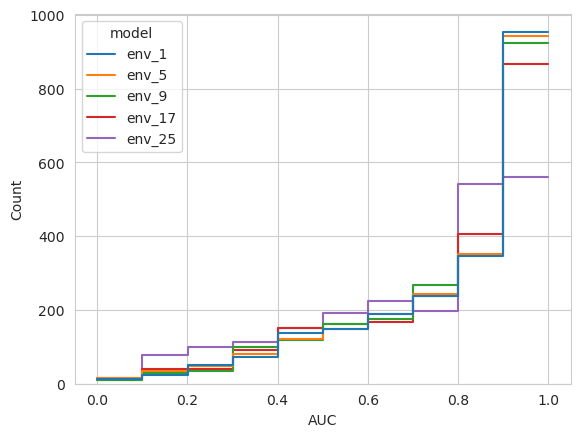

In [55]:
sns.set_style('whitegrid')
sns.histplot(plot_df[plot_df['model'].isin(['env_1', 'env_5', 'env_9', 'env_17', 'env_25'])], x='AUC', hue='model', element='step', fill=False, bins=10)

<AxesSubplot: xlabel='AUC', ylabel='Count'>

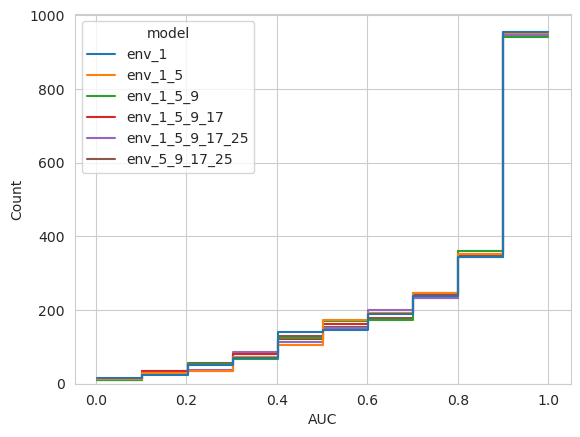

In [56]:
sns.histplot(plot_df[plot_df['model'].isin(['env_1', 'env_1_5', 'env_1_5_9','env_1_5_9_17','env_1_5_9_17_25','env_5_9_17_25'])], x='AUC', hue='model', element='step', fill=False, bins=10)

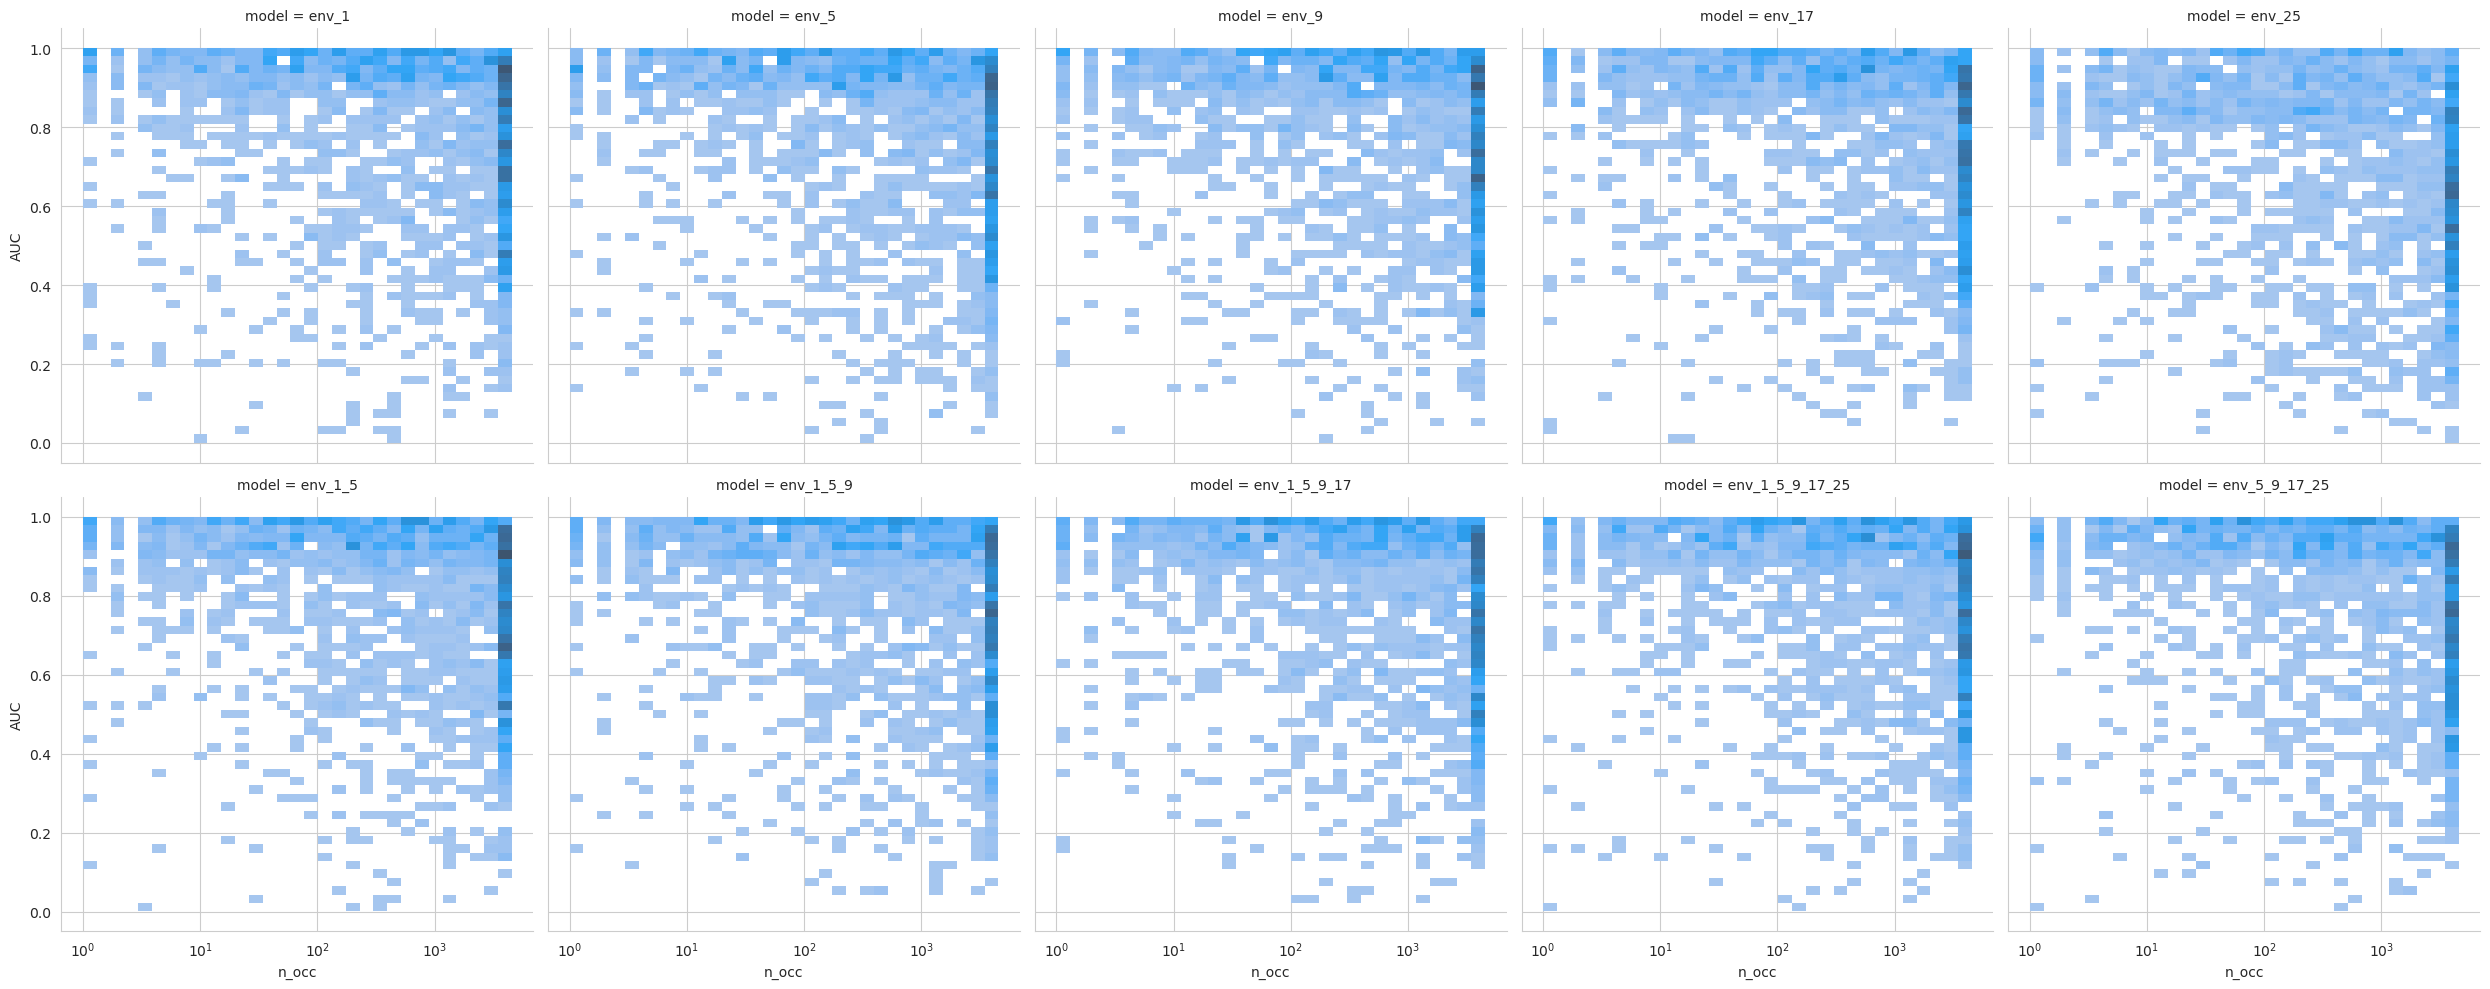

In [57]:
sns.displot(plot_df, x='n_occ', y='AUC', col='model', log_scale=(True, False), col_wrap=5)

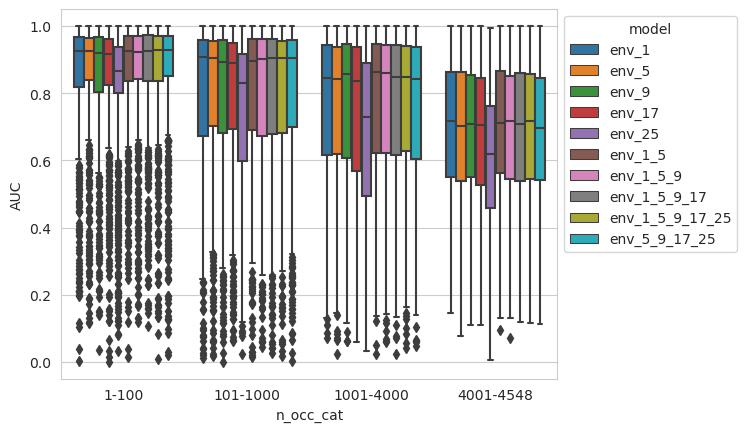

In [58]:
ax = sns.boxplot(plot_df, x='n_occ_cat', y='AUC', hue='model', order=['1-100','101-1000','1001-4000','4001-4548'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

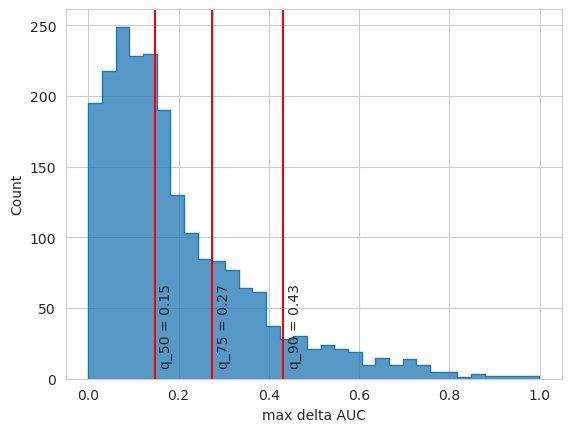

In [63]:
ax = sns.histplot((auc_df.max(axis=1) - auc_df.min(axis=1)), cumulative=False, element='step')
ax.set(xlabel='max delta AUC')#, ylabel= 'proportion of species')
for q in [0.5, 0.75, 0.9]:
    q_val = (auc_df.max(axis=1) - auc_df.min(axis=1)).quantile(q)
    ax.axvline(q_val, color='red')
    ax.text(q_val+0.01, 10, f"q_{round(q*100)} = {round(q_val, 2)}", rotation=90)

In [65]:
delta_auc_env_1 = auc_df.sub(pd.Series(auc_df['env_1']), axis=0).drop('env_1', axis=1)
delta_auc_env_1

,,env_5,env_9,env_17,env_25,env_1_5,env_1_5_9,env_1_5_9_17,env_1_5_9_17_25,env_5_9_17_25
species,n_occ,,,,,,,,,
1,2261,-0.015333,0.146963,0.252410,0.151580,0.080430,0.122932,0.143645,0.176283,0.055996
5,4529,0.040496,-0.069081,-0.032433,0.099292,0.095232,0.015750,-0.017588,-0.063664,-0.017136
10,2162,-0.019023,0.003121,-0.010655,-0.081340,0.001238,-0.020100,-0.009417,-0.021768,0.018808
11,4508,0.020936,-0.031646,-0.089546,-0.072230,-0.066076,-0.071771,0.003586,0.010623,-0.073888
24,4539,0.006648,0.012653,0.020901,-0.144398,0.002402,0.000433,-0.005385,0.007911,-0.003449
...,...,...,...,...,...,...,...,...,...,...
10028,204,0.037525,0.071015,0.031249,-0.080520,0.070522,0.065949,0.073974,-0.028424,-0.035956
10031,20,0.596208,0.755278,0.447089,0.842947,0.470620,0.646228,0.540003,0.630496,0.576980
10035,110,0.035140,-0.016269,-0.049810,-0.086112,-0.098003,-0.042197,-0.043940,-0.079207,-0.145749


/home/nina/miniconda3/envs/glc23/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nina/miniconda3/envs/glc23/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1088647/1508861424.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(pd.melt(delta_auc_env_1[['env_5','env_9','env_17','env_25']].reset_index(), id_vars=['species','n_occ']), x='value', hue='variable', kind='kde', log_scale=True)


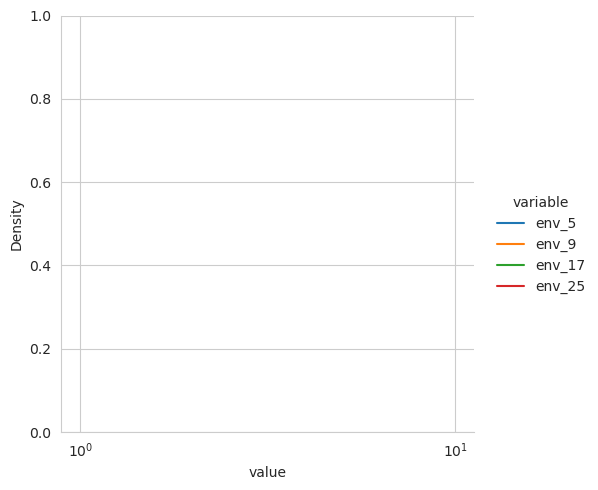

In [66]:
sns.displot(pd.melt(delta_auc_env_1[['env_5','env_9','env_17','env_25']].reset_index(), id_vars=['species','n_occ']), x='value', hue='variable', kind='kde', log_scale=True)

[Text(0.5, 0, 'delta AUC'), Text(0, 0.5, 'proportion of species')]

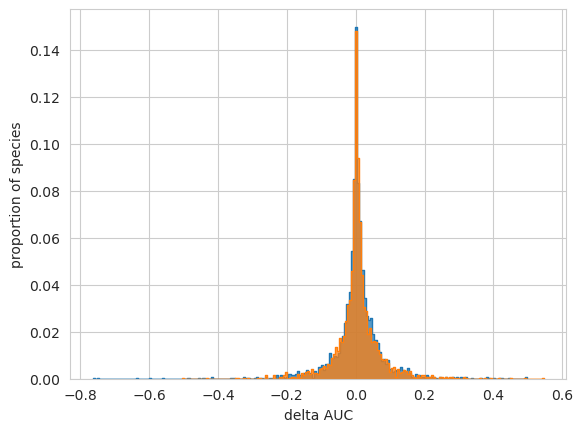

In [31]:
ax = sns.histplot((auc_df['env_1'] - auc_df['env_5']), stat='probability', cumulative=False, element='step')
ax = sns.histplot((auc_df['env_1_5_9_17'] - auc_df['env_5']), stat='probability', cumulative=False, element='step')

ax.set(xlabel='delta AUC', ylabel= 'proportion of species')

[Text(0.5, 0, 'delta AUC'), Text(0, 0.5, 'proportion of species')]

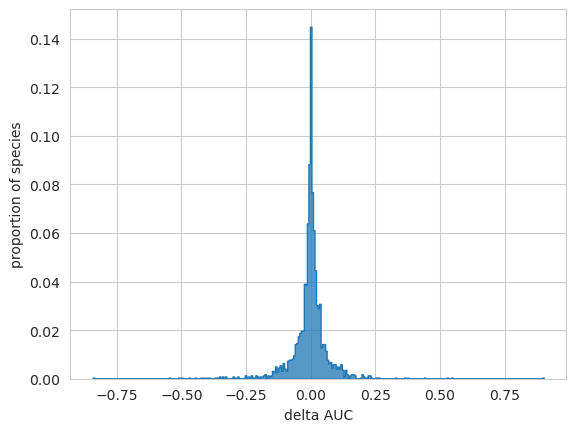

In [228]:
ax = sns.histplot((auc_df['env_1'] - auc_df['env_1_5']), stat='probability', cumulative=False, element='step')
ax.set(xlabel='delta AUC', ylabel= 'proportion of species')
# for q in [0.5, 0.75, 0.9]:
#     q_val = (auc_df.max(axis=1) - auc_df.min(axis=1)).quantile(q)
#     ax.axvline(q_val, color='red')
#     ax.text(q_val+0.01, 0.01, f"q_{round(q*100)} = {round(q_val, 2)}", rotation=90)

In [67]:
rank_df = auc_df.rank(axis=1, method='min', ascending=False)
rank_df

,,env_1,env_5,env_9,env_17,env_25,env_1_5,env_1_5_9,env_1_5_9_17,env_1_5_9_17_25,env_5_9_17_25
species,n_occ,,,,,,,,,,
1,2261,9.0,10.0,4.0,1.0,3.0,7.0,6.0,5.0,2.0,8.0
5,4529,5.0,3.0,10.0,8.0,1.0,2.0,4.0,7.0,9.0,6.0
10,2162,4.0,7.0,2.0,6.0,10.0,3.0,8.0,5.0,9.0,1.0
11,4508,4.0,1.0,5.0,10.0,8.0,6.0,7.0,3.0,2.0,9.0
24,4539,7.0,4.0,2.0,1.0,10.0,5.0,6.0,9.0,3.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...
10028,204,7.0,5.0,2.0,6.0,10.0,3.0,4.0,1.0,8.0,9.0
10031,20,10.0,5.0,2.0,9.0,1.0,8.0,3.0,7.0,4.0,6.0
10035,110,2.0,1.0,3.0,6.0,8.0,9.0,4.0,5.0,7.0,10.0


In [68]:
top_1_and_top_3 = pd.concat([
    pd.DataFrame({
        "percent_species": (rank_df == 1).sum(axis=0) / auc_df.shape[0] * 100,
        "median_AUC": auc_df[rank_df == 1].median(),
        "top-k": 1
    }),
        pd.DataFrame({
        "percent_species": (rank_df <=3).sum(axis=0) / auc_df.shape[0] * 100,
        "median_AUC": auc_df[rank_df <=3].median(),
        "top-k": 3
    })
]).reset_index(names='model')
top_1_and_top_3

,model,percent_species,median_AUC,top-k
0,env_1,9.705612,0.947250,1
1,env_5,9.107636,0.930667,1
2,env_9,12.649494,0.940645,1
3,env_17,8.509660,0.928823,1
4,env_25,12.971481,0.856017,1
5,env_1_5,12.649494,0.931177,1
6,env_1_5_9,9.751610,0.924981,1
7,env_1_5_9_17,8.049678,0.948127,1
8,env_1_5_9_17_25,9.015639,0.952360,1
9,env_5_9_17_25,13.247470,0.942404,1


/tmp/ipykernel_1088647/2976063310.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)


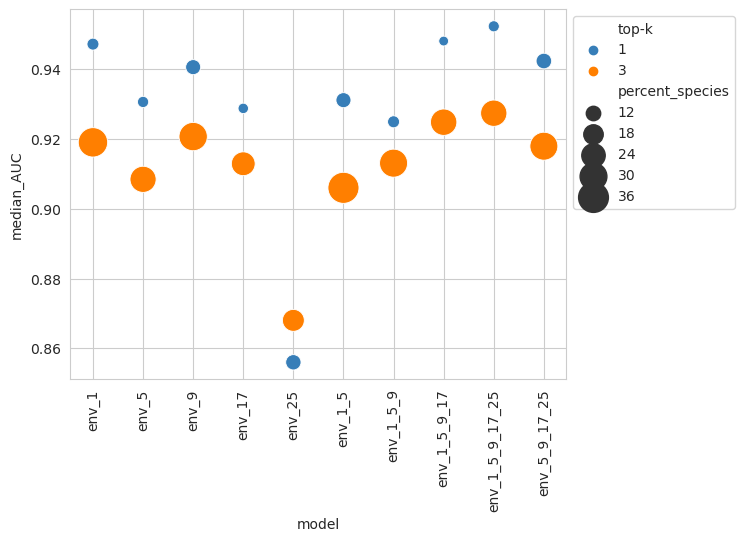

In [73]:
ax = sns.scatterplot(top_1_and_top_3, x='model', y='median_AUC', hue='top-k', size='percent_species', sizes=(50,500), palette=['#377eb8','#ff7f00'])
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [74]:
top_1_and_top_3

,model,percent_species,median_AUC,top-k
0,env_1,9.705612,0.947250,1
1,env_5,9.107636,0.930667,1
2,env_9,12.649494,0.940645,1
3,env_17,8.509660,0.928823,1
4,env_25,12.971481,0.856017,1
5,env_1_5,12.649494,0.931177,1
6,env_1_5_9,9.751610,0.924981,1
7,env_1_5_9_17,8.049678,0.948127,1
8,env_1_5_9_17_25,9.015639,0.952360,1
9,env_5_9_17_25,13.247470,0.942404,1


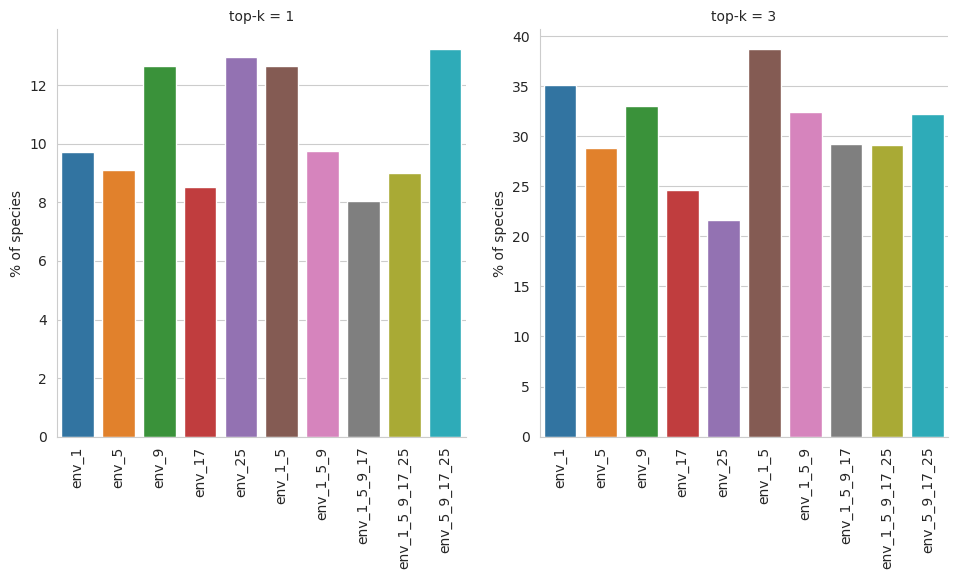

In [76]:
sns.set_style('whitegrid')
ax = sns.catplot(top_1_and_top_3, kind='bar', col='top-k', x='model', y='percent_species', sharey=False)
ax.set(xlabel='', ylabel="% of species")
ax.set_xticklabels(rotation=90)

In [100]:
pred = np.load('models/0618_env_1/y_pred_best_val_auc.npy')
true = np.load('models/0618_env_1/y_true.npy')
print(pred.shape, true.shape)

(7438, 2174) (7438, 2174)


In [106]:
pred[0,:].argsort()

array([ 778, 1925,  452, ..., 1285,  455, 1844])

<AxesSubplot: >

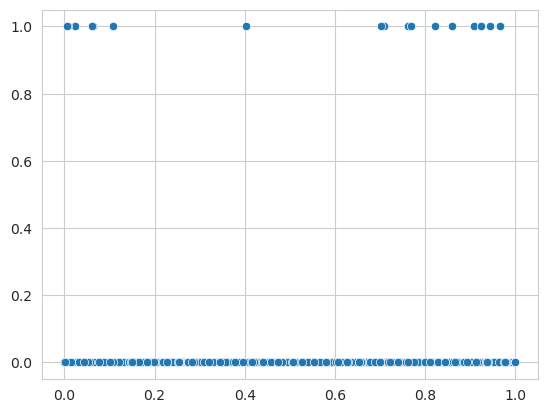

In [103]:
sns.scatterplot(x=pred[0,:], y=true[0,:])

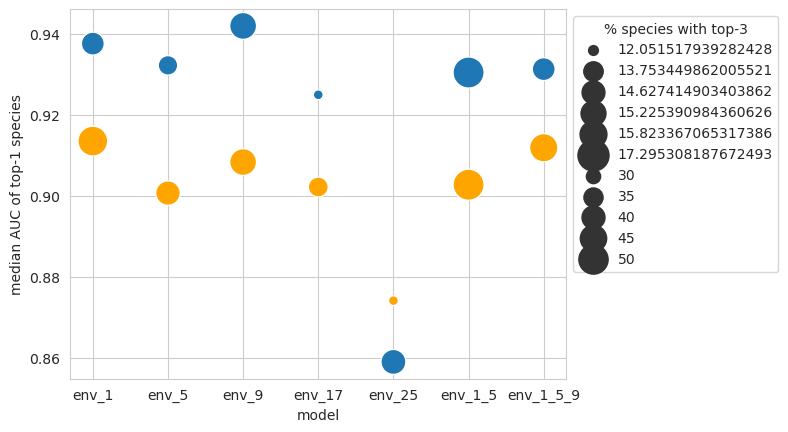

In [189]:
ax = sns.scatterplot(percent_species_with_rank.reset_index(names='model'), x='model', y='median AUC of top-1 species', size='% species with top-1', sizes=(50, 500))#pointplot to it scat
ax = sns.scatterplot(percent_species_with_rank.reset_index(names='model'), x='model', y='median AUC of top-3 species', size='% species with top-3', sizes=(50, 500), color='orange')#pointplot to it scat
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [138]:
tmp = pd.melt(auc_df[rank_df == 1].reset_index(), id_vars=['species','n_occ'], var_name='model', value_name='AUC').dropna()
tmp

,species,n_occ,model,AUC
14,101,246,env_1,0.999597
18,119,74,env_1,0.955003
20,124,7,env_1,0.961370
24,135,2,env_1,0.827034
31,159,291,env_1,0.951657
...,...,...,...,...
15186,9878,1034,env_1_5_9,0.952461
15188,9885,847,env_1_5_9,0.958126
15193,9911,364,env_1_5_9,0.983728
15194,9920,3902,env_1_5_9,0.999933


/home/nina/miniconda3/envs/glc23/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


<AxesSubplot: xlabel='model', ylabel='AUC'>

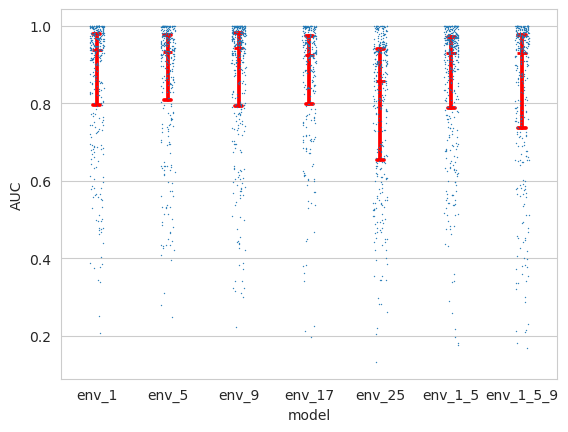

In [183]:
sns.stripplot(tmp, x='model', y='AUC', dodge=True, alpha=0.9, s=1)
sns.pointplot(tmp, x='model', y='AUC', linestyles="none", estimator="median", errorbar=('pi', 50), capsize = 0.1, markers='_', color='red')

<AxesSubplot: xlabel='model', ylabel='AUC'>

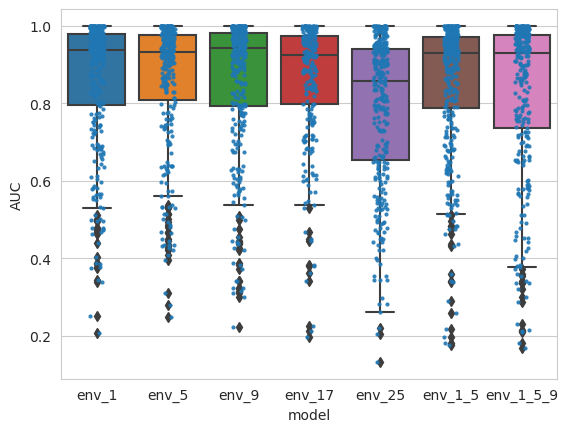

In [185]:
sns.stripplot(tmp, x='model', y='AUC', dodge=True, alpha=0.9, s=3)
sns.boxplot(tmp, x='model', y='AUC')

In [25]:
run_name = '0527_glc24_env_1_val_france'
path_to_config = f"{modeldir}{run_name}/config.json"
with open(path_to_config, "r") as f: 
    config = json.load(f)
config = {k: v if v != "" else None for k,v in config.items()}

log_wandb = config['log_wandb']
wandb_project = config['wandb_project']
wandb_id = config['wandb_id']
env_model = config['env_model']
sat_model = config['sat_model']
dataset = config['dataset']
random_bg = config['random_bg']
n_max_low_occ = config['n_max_low_occ']
embed_shape = config['embed_shape']
loss = config['loss']
lambda2 = config['lambda2']
n_epochs = config['n_epochs']
batch_size = config['batch_size']
learning_rate = config['learning_rate']
weight_decay = config['weight_decay']
num_workers_train = config['num_workers_train']
num_workers_val = config['num_workers_val']
seed = config['seed']

In [26]:
seed_everything(seed)
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {dev}")

train_data, val_data, model, optimizer, multimodal, autoencoder = setup_model(
    env_model=env_model,
    sat_model=sat_model,
    dataset=dataset,
    random_bg=random_bg,
    n_max_low_occ=n_max_low_occ,
    embed_shape=embed_shape, 
    learning_rate=learning_rate, 
    weight_decay=weight_decay,
    seed=seed) 
model = model.to(dev)

DEVICE: cuda

Making patch providers with size=10x10, flatten=False for covariates:
	 - data/GLC24/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/
	 - data/GLC24/EnvironmentalRasters/Soilgrids/
	 - data/GLC24/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif

Making patch providers with size=10x10, flatten=False for covariates:
	 - data/GLC24/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/
	 - data/GLC24/EnvironmentalRasters/Soilgrids/
	 - data/GLC24/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif

Making dataset for training occurrences
nb items = 3894962
input shape: [(41, 10, 10)]

Making dataset for validation occurrences
nb items = 88987

Making model


In [27]:
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size, num_workers=num_workers_val)

In [28]:
checkpoint = torch.load(f"{modeldir}{run_name}/last.pth")
start_epoch = checkpoint['epoch'] + 1
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [42]:
model.eval()
labels_list, y_pred_list = [], []
for inputs, _, labels in tqdm(val_loader):
    labels = labels.to(torch.float32).to(dev) 
    labels_list.append(labels.cpu().detach().numpy())

    inputs = inputs[0].to(torch.float32).to(dev)
    y_pred = torch.sigmoid(model(inputs))

    y_pred_list.append(y_pred.cpu().detach().numpy())
      
labels = np.concatenate(labels_list)
y_pred = np.concatenate(y_pred_list)

# validation AUC

# auc = roc_auc_score(labels, y_pred)
# print(auc)

100%|██████████| 348/348 [00:10<00:00, 33.86it/s]


In [43]:
labels = labels[:, val_data.species_pred_in_data]
y_pred = y_pred[:, val_data.species_pred_in_data]

In [45]:
print(labels.shape, y_pred.shape)

(88987, 4367) (88987, 4367)


In [36]:
from torcheval.metrics.functional import binary_auroc

In [52]:
pred_torch = torch.from_numpy(y_pred.T)
labels_torch = torch.from_numpy(labels.T)
print(pred_torch.shape, labels_torch.shape)

torch.Size([4367, 88987]) torch.Size([4367, 88987])


In [57]:
labels_torch.shape[0]

4367

In [54]:
start = time.time()
auc = binary_auroc(pred_torch, labels_torch, num_tasks=4367)
end = time.time()
print(auc.mean())
print(end-start)

tensor(0.8514, dtype=torch.float64)
9.726004838943481


In [61]:
auc.median().item()#cpu().detach().number()

0.9502361038433524

In [51]:
labels_filter = labels[:, :100]
y_pred_filter = y_pred[:, :100]
start = time.time()
auc = roc_auc_score(labels_filter, y_pred_filter)
end = time.time()
print(auc)
print(end-start)

0.8317704038395496
20.06242036819458


In [14]:
auc_df.reset_index()[auc_df.reset_index()['species'].isin(n_occ_val[n_occ_val >= 5].index)][auc_df.reset_index()['n_occ'] <= 50].mean()

/tmp/ipykernel_810942/820455611.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  auc_df.reset_index()[auc_df.reset_index()['species'].isin(n_occ_val[n_occ_val >= 5].index)][auc_df.reset_index()['n_occ'] <= 50].mean()


species              4883.902062
n_occ                  16.329897
env_3res                0.773105
sat_3res                0.788907
env_3res_sat_3res       0.859192
dtype: float64

In [2]:
from train_model import *

In [3]:
run_name = '0527_glc24_env_1'
path_to_config = modeldir + run_name + '/config.json'
with open(path_to_config, "r") as f:
    config = json.load(f)
config = {k: v if v != "" else None for k,v in config.items()}
log_wandb = config['log_wandb']
wandb_project = config['wandb_project']
wandb_id = config['wandb_id']
env_model = config['env_model']
sat_model = config['sat_model']
dataset = config['dataset']
random_bg = config['random_bg']
n_max_low_occ = config['n_max_low_occ']
embed_shape = config['embed_shape']
loss = config['loss']
lambda2 = config['lambda2']
n_epochs = config['n_epochs']
batch_size = config['batch_size']
learning_rate = config['learning_rate']
weight_decay = config['weight_decay']
num_workers_train = config['num_workers_train']
num_workers_val = config['num_workers_val']
seed = config['seed']
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_data, val_data, model, optimizer, multimodal, autoencoder = setup_model(
    env_model=env_model,
    sat_model=sat_model,
    dataset=dataset,
    random_bg=random_bg,
    n_max_low_occ=n_max_low_occ,
    embed_shape=embed_shape, 
    learning_rate=learning_rate, 
    weight_decay=weight_decay,
    seed=seed) 
model = model.to(dev)


Making patch providers with size=10x10, flatten=False for covariates:
	 - data/glc24_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/
	 - data/glc24_data/EnvironmentalRasters/Soilgrids/
	 - data/glc24_data/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif

Making patch providers with size=10x10, flatten=False for covariates:
	 - data/glc24_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/
	 - data/glc24_data/EnvironmentalRasters/Soilgrids/
	 - data/glc24_data/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif

Making dataset for training occurrences
nb items = 3894962
nb species = 9709
input shape: [(41, 10, 10)]

Making dataset for validation occurrences
nb items = 88987
nb species = 9709

Making model


NameError: name 'dev' is not defined

In [5]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(dev)

In [6]:
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size, num_workers=num_workers_val)

In [7]:
labels_list = []
for inputs, _, labels in tqdm(val_loader):
    labels = labels.to(torch.float32).to(dev) 
    labels_list.append(labels.cpu().detach().numpy())
labels = np.concatenate(labels_list)

100%|██████████| 348/348 [00:08<00:00, 42.28it/s]


In [8]:
labels.shape

(88987, 9709)

In [11]:
labels.sum(axis=0).shape

(9709,)

In [43]:
np.sum(labels.sum(axis=0) == 0)

5342

In [26]:
species_to_select = [s in val_data.species_counts.index for s in val_data.species]

In [27]:
labels[:,species_to_select].shape

(88987, 4367)

In [44]:
np.sum(labels[:,species_to_select].sum(axis=0) == 0)

0

In [17]:
train_data.species_counts

0.0         67
1.0          1
2.0        248
4.0          1
5.0         42
          ... 
11248.0     12
11250.0     13
11252.0     12
11253.0     23
11254.0      4
Length: 9709, dtype: int64

In [4]:
loss_fn = eval(loss)
species_weights = torch.tensor(train_data.species_weights).to(dev)
val_loss_fn = torch.nn.BCELoss()

In [5]:
checkpoint = torch.load(f"{modeldir}{run_name}/best_val_auc.pth")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch'] + 1
max_val_auc = checkpoint['val_auc']
print(epoch, max_val_auc)

26 0.8193423272756075


In [8]:
# evaluate model on validation set
model.eval()
val_loss_list, val_classif_loss_list, val_reconstr_loss_list, labels_list, y_pred_list = [], [], [], [], []
for inputs, _, labels in tqdm(val_loader):
    labels = labels.to(torch.float32).to(dev) 
    labels_list.append(labels.cpu().detach().numpy())

    if multimodal:
        inputsA = inputs[0].to(torch.float32).to(dev)
        inputsB = inputs[1].to(torch.float32).to(dev)
        y_pred = torch.sigmoid(model(inputsA, inputsB))
    else:
        inputs = inputs[0].to(torch.float32).to(dev)
        y_pred = torch.sigmoid(model(inputs))

    y_pred_list.append(y_pred.cpu().detach().numpy())

labels = np.concatenate(labels_list)
y_pred = np.concatenate(y_pred_list)

  0%|          | 0/30 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 23.69 GiB total capacity; 22.79 GiB already allocated; 275.94 MiB free; 23.02 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
np.save(f"{modeldir}{run_name}/y_pred_best_val_auc.pth", y_pred)
np.save(f"{modeldir}{run_name}/y_true.pth", labels)

In [ ]:

        # validation AUC
        auc = roc_auc_score(labels, y_pred)
        auc_low_occ = roc_auc_score(labels[:, train_data.low_occ_species_idx], y_pred[:, train_data.low_occ_species_idx])

        # if autoencoder:
        #     avg_val_classif_loss = np.mean(val_classif_loss_list)
        #     avg_val_reconstr_loss = np.mean(val_reconstr_loss_list, axis=0)
        #     print(f"\tVALIDATION LOSS={avg_val_loss} (classification loss={avg_val_classif_loss}, reconstruction loss={avg_val_reconstr_loss}) \nVALIDATION AUC={auc}")
        # else:
        print(f"\tVALIDATION LOSS={avg_val_loss} \nVALIDATION AUC={auc}")

        df = pd.DataFrame(train_data.species_counts, columns=['n_occ']).reset_index().rename(columns={'index':'species'})
        df['auc'] = [roc_auc_score(labels[:,i], y_pred[:,i]) for i in range(labels.shape[1])]
        df.to_csv(f"{modeldir}{run_name}/last_species_auc.csv", index=False)

        if log_wandb:
            wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss, "val_auc": auc, "val_auc_low_occ": auc_low_occ})
            # if autoencoder:
            #     wandb.log({"train_total_loss": avg_train_loss, "val_total_loss": avg_val_loss})
            #     if len(avg_train_reconstr_loss) == 1:
            #         wandb.log({"train_reconstr_loss_1": avg_train_reconstr_loss[0], "val_reconstr_loss_1": avg_val_reconstr_loss[0]})
            #     elif len(avg_train_reconstr_loss) == 3:
            #         wandb.log({
            #             "train_reconstr_loss_1": avg_train_reconstr_loss[0], "train_reconstr_loss_2": avg_train_reconstr_loss[1], "train_reconstr_loss_3": avg_train_reconstr_loss[2],
            #             "val_reconstr_loss_1": avg_val_reconstr_loss[0], "val_reconstr_loss_2": avg_val_reconstr_loss[1], "val_reconstr_loss_3": avg_val_reconstr_loss[2]
            #         })
            #     else:
            #         print('cannot log reconstruction losses!')

        # model checkpoint
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_auc': auc
        }, f"{modeldir}/{run_name}/last.pth") 

        # save best model
        if auc > max_val_auc:
            max_val_auc = auc
            df.to_csv(f"{modeldir}{run_name}/best_val_auc_species_auc.csv", index=False)
            torch.save({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'val_auc': auc
            }, f"{modeldir}{run_name}/best_val_auc.pth")  

    

# run_name = '0510_multimodel_multires'
# path_to_config = f"{modeldir}{run_name}/config.json"
# with open(path_to_config, "r") as f: 
#     config = json.load(f)
# config = {k: v if v != "" else None for k,v in config.items()}
# model_setup = {}

# if config['env_model'] is not None: 
#     config['env_model']['covariates'] = [eval(f) for f in config['env_model']['covariates']]
#     model_setup['env'] = config['env_model']

# if config['sat_model'] is not None: 
#     config['sat_model']['covariates'] = [eval(f) for f in config['sat_model']['covariates']]
#     model_setup['sat'] = config['sat_model']

# train_occ_path = eval(config['train_occ_path'])
# random_bg_path = eval(config['random_bg_path']) if config['random_bg_path'] is not None else None
# val_occ_path = eval(config['val_occ_path'])
# n_max_low_occ = config['n_max_low_occ']
# embed_shape = config['embed_shape']
# loss = config['loss']
# lambda2 = config['lambda2']
# n_epochs = config['n_epochs']
# batch_size = config['batch_size']
# learning_rate = config['learning_rate']
# weight_decay = config['weight_decay']
# num_workers_train = config['num_workers_train']
# num_workers_val = config['num_workers_val']
# seed = config['seed']